# **Import libraries**

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from keras.src.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Model
from keras.applications import ResNet50
from keras.models import Sequential
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

## Load Data & Encoding labels ##

In [3]:
#IMG_SIZE=256
IMG_SIZE=224
data_path="/kaggle/input/product-classification/Product Classification/"

In [4]:
def Data_Preprocessing(root_folder,folder, IMG_SIZE):
    path_images = []
    labels = []

    # Iterate through each product folder
    for product_folder in os.listdir(root_folder):
        product_path = os.path.join(root_folder, product_folder)

        # List all image files in the training folder
        training_folder = os.path.join(product_path, folder)
        training_images = [os.path.join(training_folder, f) for f in os.listdir(training_folder)]
        # Add the paths and labels to the lists
        path_images.extend(training_images)
        labels.extend([int(product_folder)] * len(training_images))
    images=[]
    for path in path_images:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
    images = np.array(images, dtype='float32') / 255.0

    return images,labels

In [5]:
X_train, labels = Data_Preprocessing(data_path, 'Train',IMG_SIZE)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [6]:
onehotencoder = OneHotEncoder()
labels = np.array(labels).reshape(-1,1)
labels = onehotencoder.fit_transform(labels).toarray()
y_train=labels

## Augmentation For Train ##

In [7]:
training_datagen = ImageDataGenerator(
     horizontal_flip=True,
     vertical_flip=True,
     rotation_range=40,
     width_shift_range=0.2,
     height_shift_range=0.2,
     zoom_range=0.2,
     fill_mode="nearest",
)

training_datagen.fit(X_train)

# **Xception Model**

In [8]:
NUM_EPOCHS = 100
BATCH_SIZE = 32
Input_Shape=(IMG_SIZE,IMG_SIZE,3)

In [9]:
base_model=tf.keras.applications.xception.Xception(input_shape=Input_Shape, weights='imagenet',include_top=False)
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

x = Dense(20, activation='Softmax')(x)

model = Model(base_model.input, x)

83683744/83683744 [==============================] - 0s 0us/step


# Compile Model

In [10]:
opt = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=opt,
              loss=tf.losses.categorical_crossentropy,
              metrics=['accuracy'])

# model.compile(optimizer='adam',
#               loss=tf.losses.categorical_crossentropy,
#               metrics=['accuracy'])

In [11]:
start_train = time.time()

# Fit Model

In [12]:
history=model.fit(training_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),epochs=NUM_EPOCHS)

Epoch 1/100
5/5 [==============================] - 10s 185ms/step - loss: 3.0143 - accuracy: 0.0786
Epoch 2/100
5/5 [==============================] - 2s 281ms/step - loss: 2.1902 - accuracy: 0.3857
Epoch 3/100
5/5 [==============================] - 1s 259ms/step - loss: 1.6046 - accuracy: 0.6714
Epoch 4/100
5/5 [==============================] - 2s 285ms/step - loss: 1.1957 - accuracy: 0.7714
Epoch 5/100
5/5 [==============================] - 2s 279ms/step - loss: 0.9310 - accuracy: 0.8071
Epoch 6/100
5/5 [==============================] - 2s 286ms/step - loss: 0.7253 - accuracy: 0.8071
Epoch 7/100
5/5 [==============================] - 2s 333ms/step - loss: 0.5449 - accuracy: 0.9071
Epoch 8/100
5/5 [==============================] - 2s 271ms/step - loss: 0.5082 - accuracy: 0.9286
Epoch 9/100
5/5 [==============================] - 1s 264ms/step - loss: 0.3444 - accuracy: 0.9857
Epoch 10/100
5/5 [==============================] - 1s 264ms/step - loss: 0.2807 - accuracy: 0.9714
Epoch 11

In [13]:
end_train_resnet = time.time()

In [14]:
model.save('Xception_Model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Plot the training accuracy and loss at each epoch # 

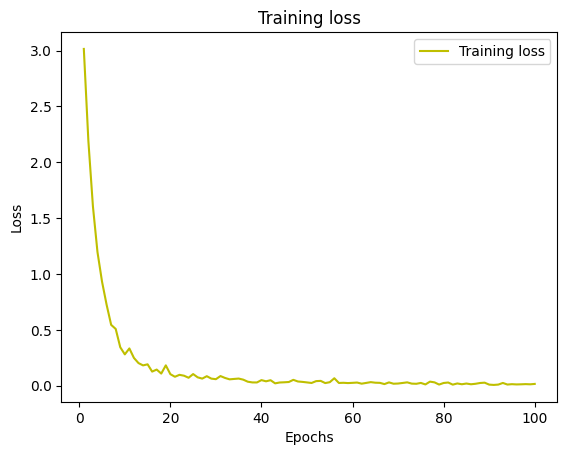

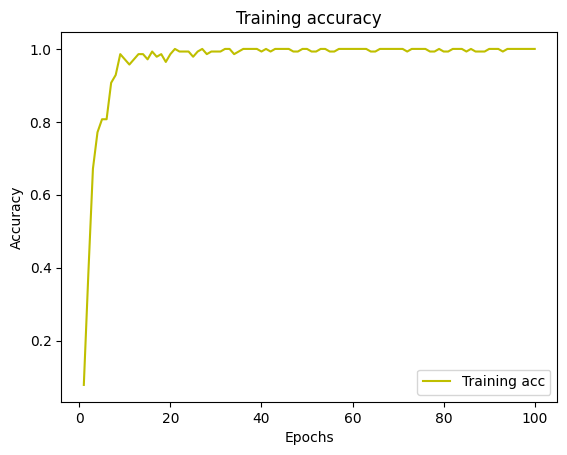

In [15]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# **Time of Training**

In [16]:
Training_time = end_train_resnet - start_train

In [17]:
print('Training Time Xception',Training_time)

Training Time Xception 161.68664455413818
